In [4]:
#set gamma to be 1 globally
GAMMA=1

In [5]:
import random
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

#basic template for an MDP
class MDP:
    @property
    def states(self):
        pass

    def actions(self, state):
        pass

    def psr(self, state, action):
        pass

In [6]:
#specific gambler's problem class, follows template
class GamblersProblem(MDP):
    '''
    The gambler's problem, as described in Example 4.3 of Sutton-Barto.
    '''

    def __init__(self, p_h, goal):
        assert 0 <= p_h <= 1
        self.p_h = p_h
        self.goal = goal

    @property
    #returns set of states of the MDP
    def states(self):
        return set(range(self.goal+1))

    #returns actions allowed given state from `state`
    def actions(self, state):
      if state in {0,self.goal}:
        return {0}
      else:
        return set(range(1, 1+min(state,self.goal-state)))

    #returns set of tuples of probability of reaching state s, state s, and reward given state s
    def psr(self, state, action):
        return {
            (
                self.p_h,
                state + action,
                1 if (state + action == self.goal and state !=self.goal) else 0
            ), (
                1 - self.p_h,
                state - action,
                0
            )
        }

    #returns plot of the policy reached by the agent
    def plot_policy(self, policy):
        for s, actions in policy.items():
            xy = [(s, action) for action in actions]
            plt.scatter(
                *zip(*xy),
                # purple if there are multiple actions
                color='purple' if len(actions) > 1 else 'blue',
                marker='.'
            )

    #plots value function
    def plot_value(self, value):
        xy = [(s, v) for s, v in value.items()]
        plt.plot(*zip(*xy))

In [7]:
#allows the agent to determine value when taking an action in a given state
class Value(dict):
    #evaluates the value function, given a state-action pair, what is the value
    def truncated_evaluations(self, mdp):
        '''
        Returns:
            (dict) The truncated policy evaluations for every state and
                every action. The keys are the states, and the values are
                dicts keyed by actions with value the truncated policy
                evaluation of performing the action at the state.
        '''
        evaluations = {
            state: {
                action: sum(prob * (reward + GAMMA * self[next_state])
                            for prob, next_state, reward in mdp.psr(state, action))
                for action in mdp.actions(state)
            } for state in mdp.states
        }
        return evaluations

    #dictates how we choose a policy given a value
    def greedy_policy(self, mdp, tiebreak='equal_split'):
        '''
        The greedy policy (with respect to the truncated policy evaluations).

        Args:
            tiebreaker: Decides what to do in case there are multiply actions
                with the same truncated policy evaluation. The options are
                'equal_split' (of the probabilities), 'max' (of the actions),
                'min' (of the actions), 'random' (action).
        '''
        greedy_actions = {
            s: {a for a, v in evals.items() if v == max(evals.values())}
            for s, evals in self.truncated_evaluations(mdp).items()
        }
        tiebreaker = lambda actions: {
            'equal_split': {a: 1 / len(actions) for a in actions},
            'max': {max(actions): 1.0},
            'min': {min(actions): 1.0},
            'random': {random.choice(list(actions)): 1.0},
        }[tiebreak]
        return {
            s: tiebreaker(actions)
            for s, actions in greedy_actions.items()
        }

In [8]:
#the agent determines optimal policy by following value iteration
def value_iteration_algorithm(mdp, theta=1e-15, max_iter=200, tiebreak='equal_split'):
    V = Value({state: 0 for state in mdp.states})
    pbar = tqdm(range(max_iter))
    for _ in pbar:
        Delta = 0
        new_V = V.copy()
        for s in mdp.states:
            v = V[s]
            new_V[s] = max(V.truncated_evaluations(mdp)[s].values())
            Delta = max(Delta, abs(v - new_V[s]))
        V.update(new_V)
        if Delta < theta:
            break
        mdp.plot_value(V)
        pbar.set_description(f'{Delta=:<6.3}  {V[50]=:<6.3}  {V[100]=:<6.3}')
    plt.show()
    return V.greedy_policy(mdp, tiebreak=tiebreak)

Delta=1.22e-15  V[50]=0.4     V[100]=0.0   :  24%|▏| 49/200 [00:06<00:19,  7.78i


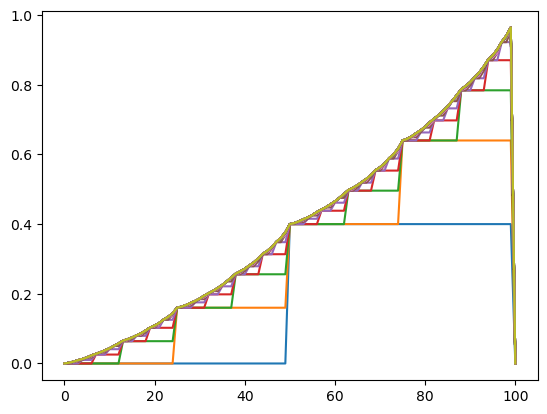

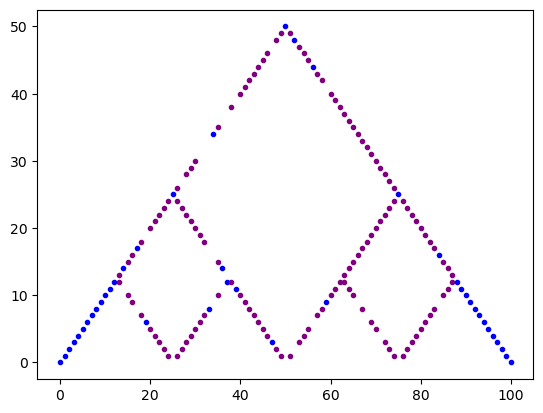

In [9]:
#try out classes above with probability 0.4, goal 100
mdp = GamblersProblem(0.4, 100)
mdp.plot_policy(value_iteration_algorithm(mdp, theta=1e-15, tiebreak='equal_split'))
plt.show()

Delta=2.33e-15  V[50]=0.25    V[100]=0.0   :  20%|▏| 41/200 [00:05<00:20,  7.74i


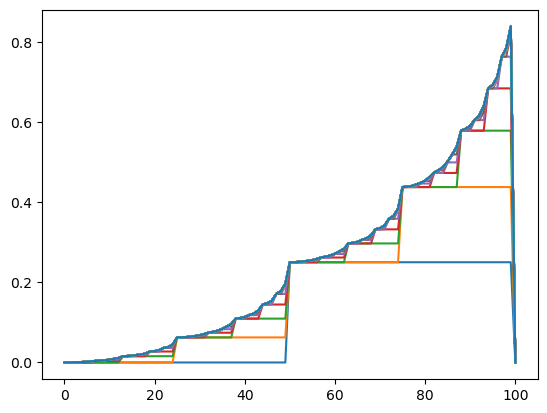

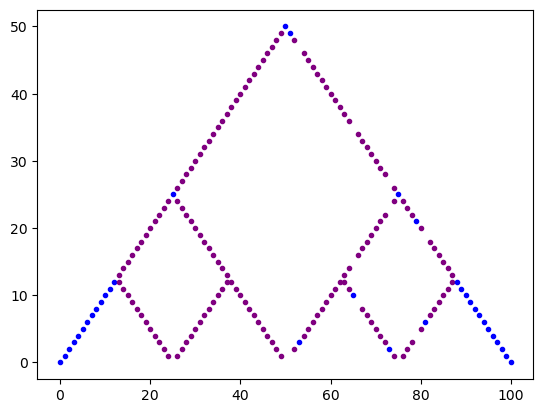

In [10]:
#another test with probability 0.25, goal 100 again
mdp = GamblersProblem(0.25, 100)
mdp.plot_policy(value_iteration_algorithm(mdp, theta=1e-15, tiebreak='equal_split'))
plt.show()

Delta=0.0013  V[50]=0.92    V[100]=0.0   : 100%|█| 200/200 [00:25<00:00,  7.91it


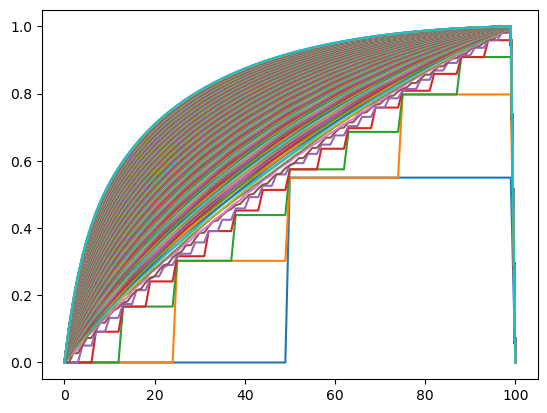

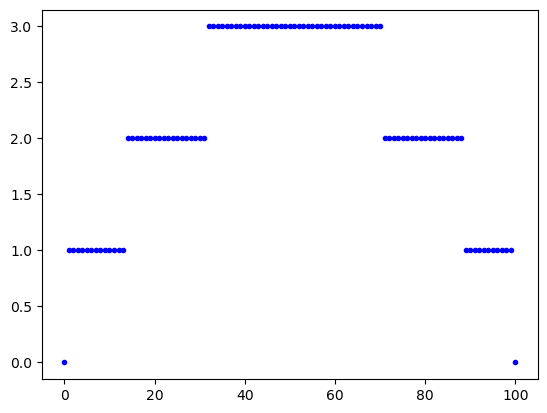

In [11]:
#final test with probability 0.55, goal 100
mdp = GamblersProblem(0.55, 100)
mdp.plot_policy(value_iteration_algorithm(mdp, theta=1e-15, tiebreak='equal_split'))
plt.show()